## Test if the calibration is doing what I expect

This calculates residual offsets from that calibrated images by applying a tailcut + some dilation around the signal, and using non-signal pixels as background.

In [1]:
from ctapipe.io.eventsourcefactory import event_source
from ctapipe.utils import datasets
from ctapipe.calib import CameraCalibrator
from ctapipe.image import tailcuts_clean, dilate
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.stats import poisson
import os
%matplotlib inline

The process_pedestal function just accumulates pixel-wise pedestal data for each event

In [2]:
hists = {}
chan = 0 # which channel to look at

def process_pedestal(event, output=False):

    for tel in event.dl0.tels_with_data:
        geom = event.inst.subarray.tel[tel].camera
        im = np.squeeze(event.dl1.tel[tel].image[chan]) 

        # select pixels that are not signal and calculate 
        # means and std of them (they should be pedestals):
        mask = tailcuts_clean(geom, im, picture_thresh=7, boundary_thresh=4)
        for ii in range(3):
            mask = dilate(geom, mask)

        if output:
            print("evt:{:10d} tel: {:03d}/{:10.10s} mean: {:5.3f} std: {:5.3f}"\
                  .format(event.dl0.event_id, tel, geom.cam_id, 
                          im[~mask].mean(), im[~mask].std()))
        
        hist, ed = np.histogram(im[~mask], bins=200, range=[-10,10])

        if geom.cam_id in hists:
            hists[geom.cam_id][0] += hist
            hists[geom.cam_id][2] += len(im[~mask]) # counter
        else:
            hists[geom.cam_id] = [hist,ed,len(im[~mask])]


Loop over events in a file and collect residual statistics on all images

In [6]:
hists = {} 
max_events = 100

for infile in [datasets.get_dataset_path('gamma_test.simtel.gz'),
              datasets.get_dataset_path('gamma_test_large.simtel.gz')]:
    # using both gamma_test and gamma_test_large to cover more camera types in the tests
    
    source = event_source(infile, max_events=max_events)

    cal = CameraCalibrator(eventsource=source)

    for event in tqdm(source, total=max_events):
        cal.calibrate(event)
        process_pedestal(event)

100%|██████████| 100/100 [00:04<00:00, 22.94it/s]


Text(0.5,1,'Residual signals after calibration')

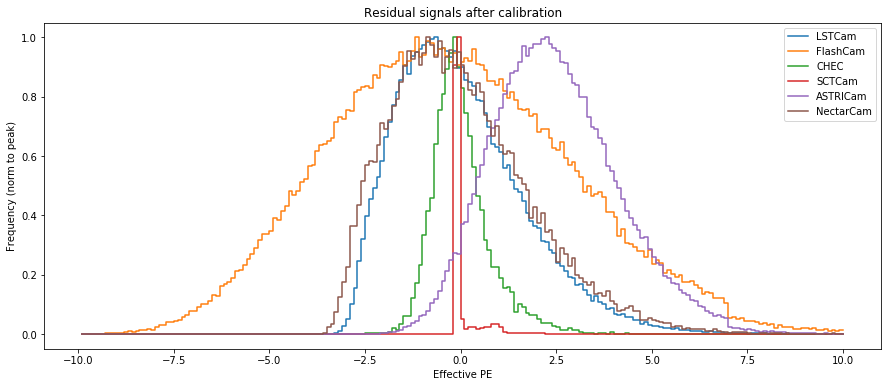

In [7]:
plt.figure(figsize=(15,6))

#poiss = poiss/poiss.max()
for cam in hists:
    X = hists[cam][1][1:]
    H = hists[cam][0]
    plt.plot(X, H/H.max(), label=cam, ls='steps')


plt.xlabel("Effective PE")
plt.ylabel("Frequency (norm to peak)")
plt.legend()
plt.title("Residual signals after calibration")